In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['font.size'] = 20
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Helvetica"

rng = np.random.default_rng(11)

In [59]:
# Monte Carlo Simulator for selling
def sim_MC(funct, # function that determines # of shares to trade at each time step
           pos_args = [],
           key_args = {},
           T = 100, # total trading period
           lamb = 1, 
           gamma = 0.5, 
           sigma = 0.3, # asset volatility
           c = 0.5, # square root law
           tau = 10, # impact decay
           start_pos = 1000, # Initial position
           p0 = 10, # initial price of asset
           n_MC = 10000, # no. of MC simulations
           ):
    '''
    Runs Monte Carlo simulations for selling with price impact for a given trading strategy funct, then returns average of relevant quantities
    '''

    J = np.zeros((n_MC, T+1)) # EWMA of past and current order flow
    I = np.zeros((n_MC, T+1)) # price impact
    X = np.zeros((n_MC, T+1)) # position (# of shares)
    W = np.zeros((n_MC, T+1)) # wealth
    alpha = np.zeros((n_MC, T+1)) # forecast
    P = np.zeros((n_MC, T+1)) # asset price
    pi = np.zeros((n_MC, T+1)) # price of buying with impact
    # Y = np.zeros(T+1) # cash position
    x = np.zeros((n_MC, T)) # quantity to trade between t and t+1

    # Initialize starting values
    P[:,0] = p0
    pi[:,0] = p0
    X[:,0] = start_pos

    key_args['tot_q'] = start_pos
    key_args['t_steps'] = T

    for i in range(T):
        if i == T-1: # if at the last time step, need to sell all shares
            x[:,i] = X[:,i]
        else:
            # determine x_t given J_{t-1}, I_{t-1}, T-t, alpha_t, X_{t-1}
            # F takes as input alpha, p ,T-t, X, input function gives execution price as function of quantity,
            # need to know decay function, alpha, how long it decays
            # x[:,i] = const_frac_F(alpha[:,i], frac, X[:,i], b)
            key_args['rem_q'] = X[:,i]
            key_args['alpha'] = alpha[:,i]
            key_args['rem_t'] = T-i
            x[:,i] = funct(*pos_args, **key_args)
            # if i == 3:
            #     print(x[:5,i]) 

        # Update variables for next time step according to equations
        J[:,i+1] = np.exp(-1/tau) * J[:,i] + 0.5 * x[:,i] * (1 + np.exp(-2/(tau)))
        I[:,i+1] = lamb * np.sign(J[:,i+1]) * np.sqrt(abs(J[:,i+1]))
        alpha[:,i+1] = np.exp(-1/tau) * alpha[:,i] + gamma * rng.standard_normal(size = n_MC)
        P[:,i+1] = P[:,i] + alpha[:,i+1] + sigma * rng.standard_normal(size = n_MC)
        pi[:,i+1] = P[:,i+1] + I[:,i+1]
        X[:,i+1] = X[:,i] - x[:,i]
        W[:,i+1] = W[:,i] + x[:,i] * pi[:,i+1] + X[:,i+1] * (P[:,i+1]-P[:,i])

    # Take mean over all MC simulations
    avg_J = np.mean(J, axis = 0)
    # avg_I = np.mean(I, axis = 0)
    avg_I = np.sqrt(avg_J)
    avg_X = np.mean(X, axis = 0)
    avg_W = np.mean(W, axis = 0)
    avg_alpha = np.mean(alpha, axis = 0)
    avg_P = np.mean(P, axis = 0)
    avg_pi = np.mean(pi, axis = 0)
    
    data = pd.DataFrame(
        {'J': avg_J,'I': avg_I, 'alpha': avg_alpha, 'P': avg_P, 'pi': avg_pi, 'X': avg_X, 'W': avg_W}
    )

    return data

# Plotter
def plot_results(f_title, df, save_fig = False, fpath = ""):
    '''
    Plot averages of MC sim with option to save fig
    '''
    
    # Create a figure and axis
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

    # Columns to plot
    cols = ['J', 'I', 'X', 'W', 'alpha', 'P', 'pi']
    ylabs = ["Order Flow", "Price Impact", "\# of Shares", "Wealth (\$)", "Forecast", "Price (\$)"]
    titles = [r"EWMA of Cumulative Order Flow ($\mathbf{J_t}$)", r"Price Impact ($\mathbf{I_t}$)", r"Position ($\mathbf{X_t}$)", r"Wealth ($\mathbf{W_t}$)", r"Forecast ($\mathbf{\alpha_t}$)", "Asset Price"]

    for i, c in enumerate(cols):
        if c == 'pi':
            axes[(i-1)%3, (i-1)//3].plot(df[c], ".-", label = r"$\mathbf{\pi_t}$")
            axes[(i-1)%3, (i-1)//3].legend()
            break
        if c == 'P':
            axes[i%3, i//3].plot(df[c], ".-", label = r"$\mathbf{P_t}$")
        else:
            axes[i%3, i//3].plot(df[c], ".-")
        
        axes[i%3, i//3].set_xlabel("Time")
        axes[i%3, i//3].set_ylabel(ylabs[i])
        axes[i%3, i//3].set_title(titles[i])

    fig.suptitle(f"{f_title}", fontsize=24, fontweight = "heavy")

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Adjust layout to prevent clipping of titles
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight')
    return fig


def plot_multi_results(f_title, df, logsc = False, save_fig=False, fpath=""):
    '''
    Plot averages of multidimensional MC sim with option to save fig
    data is a dict
    '''

    # Create a figure and axis
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 16))

    # Columns to plot
    cols = ['J', 'I', 'X', 'W', 'alpha', 'P', 'pi']
    ylabs = ["Order Flow", "Price Impact", "\# of Shares", "Wealth (\$)", "Forecast", "Price (\$)"]
    titles = [r"EWMA of Cumulative Order Flow ($\mathbf{J_t}$)", r"Price Impact ($\mathbf{I_t}$)", r"Position ($\mathbf{X_t}$)", r"Wealth ($\mathbf{W_t}$)", r"Forecast ($\mathbf{\alpha_t}$)", "Asset Price"]

    for i, c in enumerate(cols):
        for p in df.keys():
            if c == 'pi':
                axes[(i-1) % 3, (i-1) // 3].plot(df[p][c], ".-", label=rf"$\pi_t,p={p}$")
                axes[(i-1) % 3, (i-1) // 3].legend(fontsize='small', ncol = 2, )# bbox_to_anchor=(1.05, 1), loc='upper left')
            elif c == 'P':
                axes[i % 3, i // 3].plot(df[p][c], ".-", label=rf"$P_t,p={p}$")
                axes[i % 3, i // 3].legend(fontsize='small', ncol = 2, )# bbox_to_anchor=(1.05, 1), loc='upper left')
            else:
                axes[i % 3, i // 3].plot(df[p][c], ".-", label=f"p={p}")
                axes[i % 3, i // 3].legend(fontsize='small', ncol = 2, )# bbox_to_anchor=(1, 1), loc='upper left')
        if c != 'pi':
            axes[i % 3, i // 3].set_xlabel("Time")
            axes[i % 3, i // 3].set_ylabel(ylabs[i])
            axes[i % 3, i // 3].set_title(titles[i])
            if logsc:
                axes[i % 3, i // 3].set_yscale('log')

    fig.suptitle(f"{f_title}", fontsize=24, fontweight="heavy")

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Adjust layout to prevent clipping of titles
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.5)

    # Save figure
    if save_fig:
        fig.savefig(fpath, bbox_inches='tight')

    return fig

<>:88: SyntaxWarning: invalid escape sequence '\#'
<>:88: SyntaxWarning: invalid escape sequence '\$'
<>:88: SyntaxWarning: invalid escape sequence '\$'
<>:130: SyntaxWarning: invalid escape sequence '\#'
<>:130: SyntaxWarning: invalid escape sequence '\$'
<>:130: SyntaxWarning: invalid escape sequence '\$'
<>:88: SyntaxWarning: invalid escape sequence '\#'
<>:88: SyntaxWarning: invalid escape sequence '\$'
<>:88: SyntaxWarning: invalid escape sequence '\$'
<>:130: SyntaxWarning: invalid escape sequence '\#'
<>:130: SyntaxWarning: invalid escape sequence '\$'
<>:130: SyntaxWarning: invalid escape sequence '\$'
/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_2241/392637534.py:88: SyntaxWarning: invalid escape sequence '\#'
  ylabs = ["Order Flow", "Price Impact", "\# of Shares", "Wealth (\$)", "Forecast", "Price (\$)"]
/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_2241/392637534.py:88: SyntaxWarning: invalid escape sequence '\$'
  ylabs = ["Order Flow", "Price Im

In [8]:

    
# def const_frac_alpha(frac, b, rem_q, alpha, **kwargs):
#     assert 0 < frac < 1
#     return frac * rem_q - b * alpha # when selling


## Constant x {-}

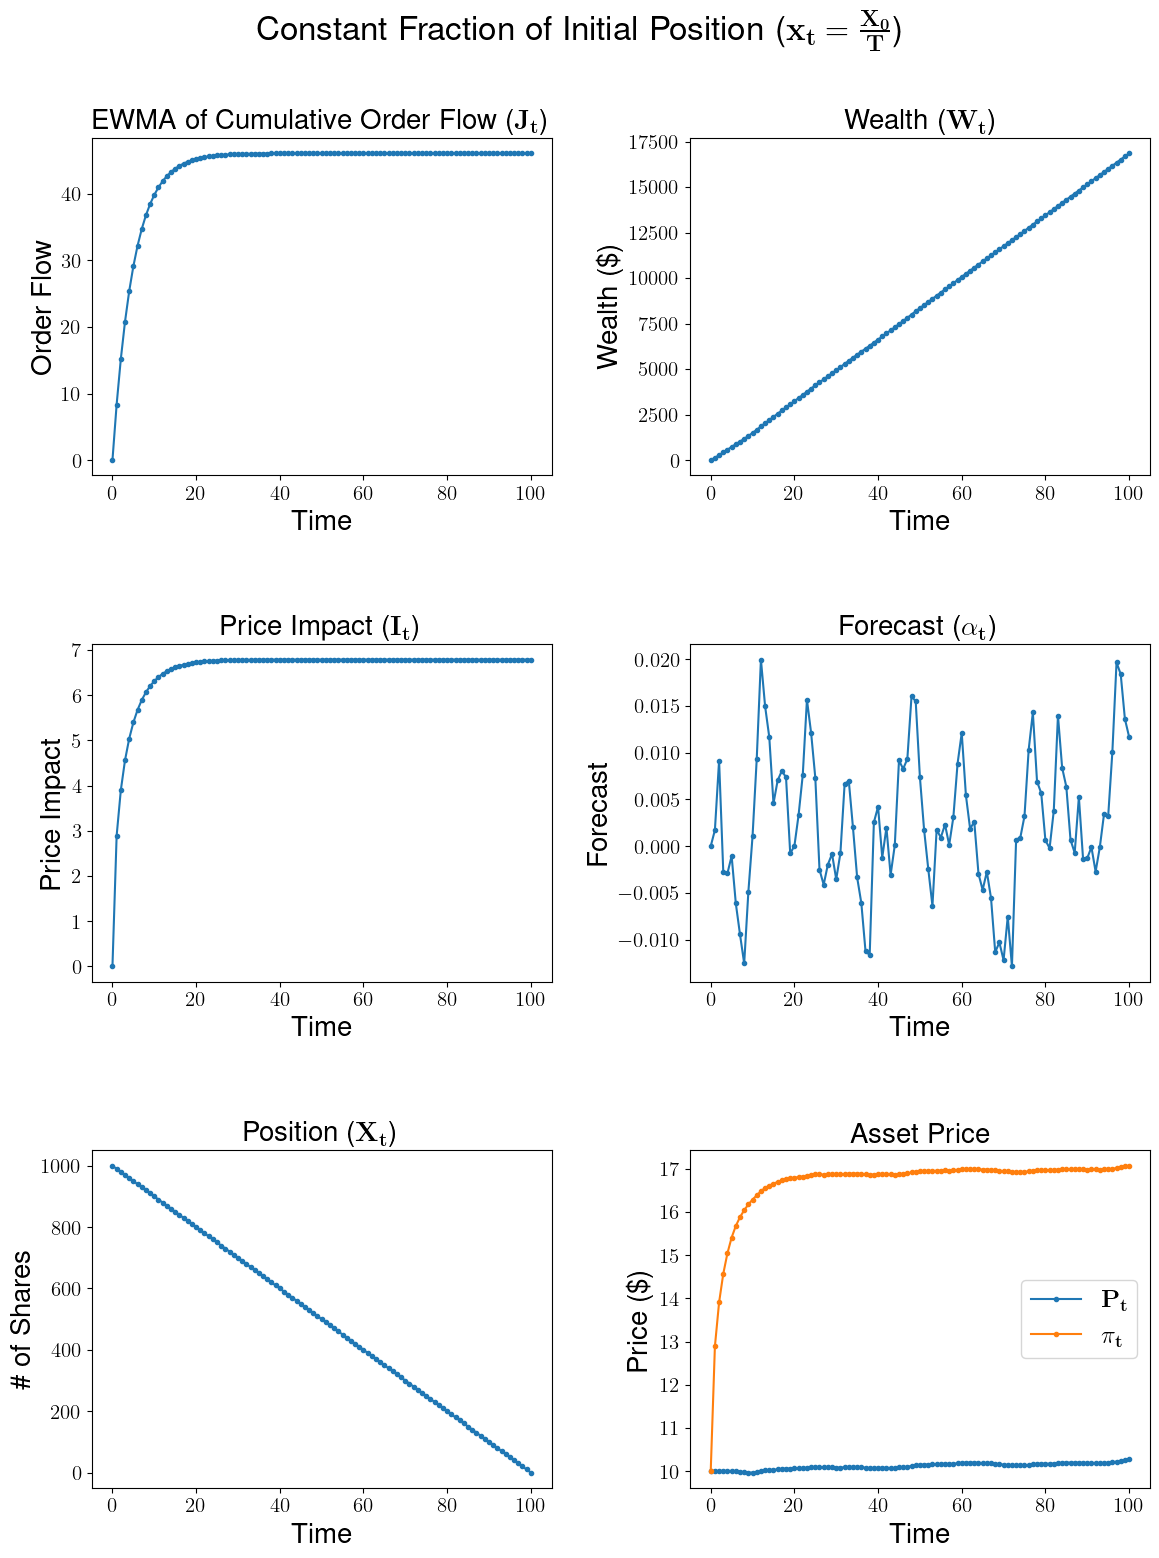

In [28]:
def const_x(tot_q, t_steps, **kwargs):
    '''
    Calculates number of shares to sell at each time step so that it's constant throughout the entire trading period from initial position and number of time steps
    '''
    assert 0 < t_steps
    return tot_q/t_steps

df = sim_MC(const_x)
plt.show(plot_results(r"Constant Fraction of Initial Position ($\mathbf{x_t=\frac{X_0}{T}}$)", df))

## Constant Fraction of Remaining Shares {-}

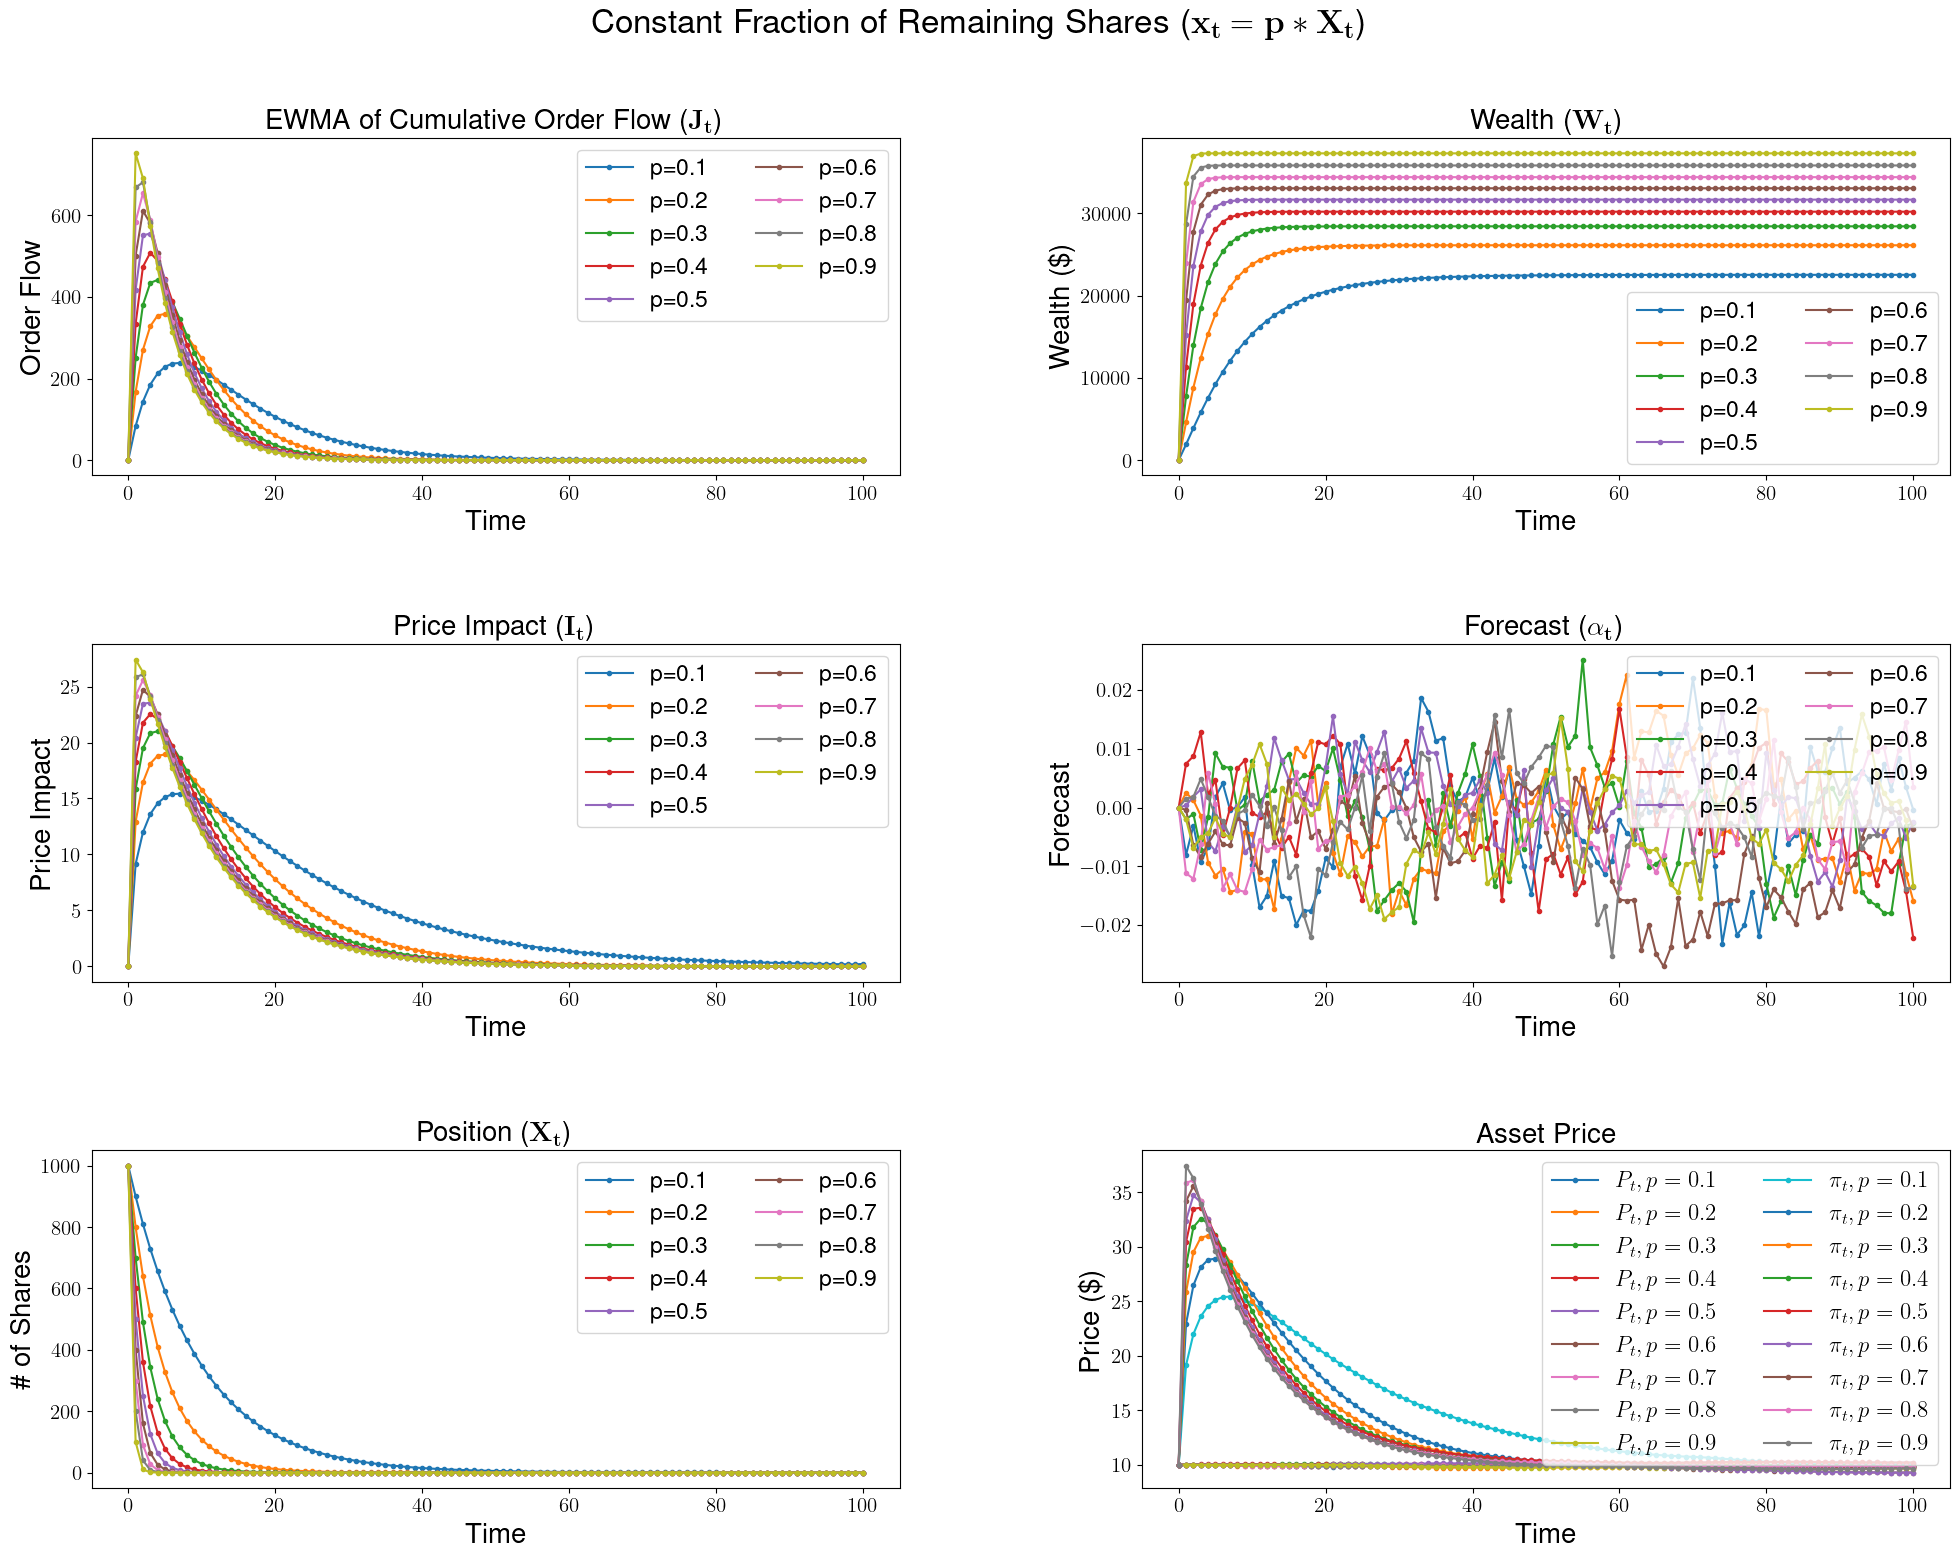

In [30]:
def const_frac(frac, rem_q, **kwargs):
    '''
    Calculates the number of shares to sell so that it's a constant fraction of the remaining shares
    '''
    assert 0 <= frac <= 1
    return frac * rem_q

const_frac_rem = pd.DataFrame()

d = {}

for i in range(1, 10):
    frac = i / 10

    d[frac] = sim_MC(const_frac, key_args = {'frac': frac})
plt.show(plot_multi_results(r"Constant Fraction of Remaining Shares ($\mathbf{x_t=p*X_t}$)", d, logsc = False))

## Linear Function of Alpha {-}

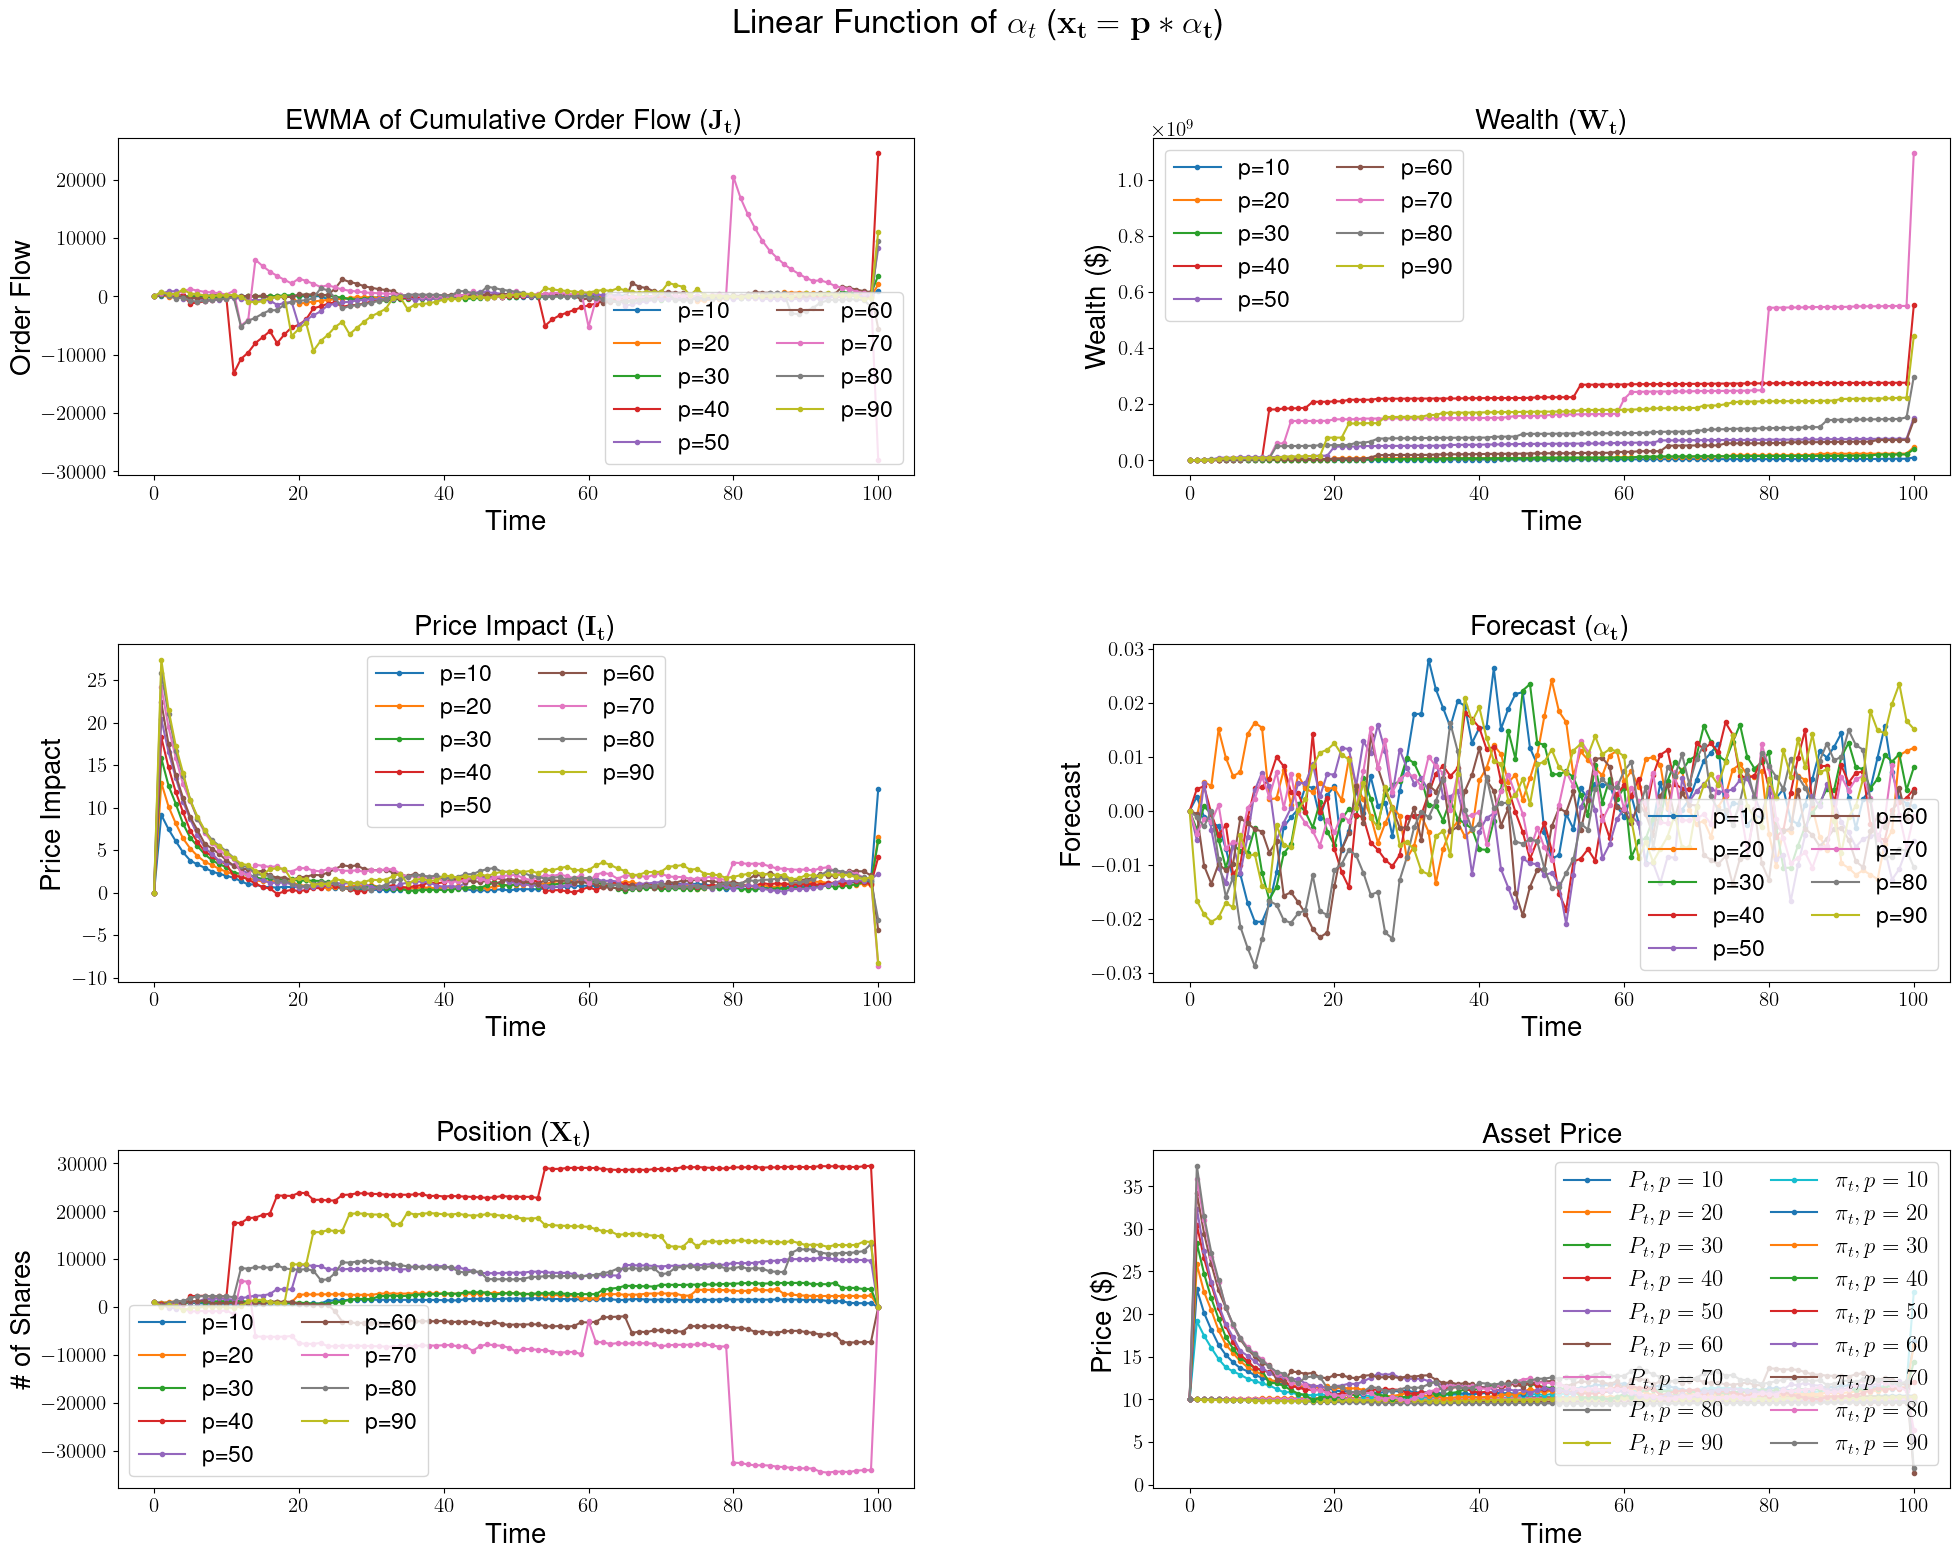

In [34]:
def lin_alpha(m, alpha, **kwargs):
    '''
    Calculates the number of shares to sell for a linear function of alpha
    '''
    return m/(alpha+0.1)

lin_alpha_df = pd.DataFrame()

d = {}

for i in range(1, 10):
    frac = 10 * i

    d[frac] = sim_MC(lin_alpha, key_args = {'m': frac})
plt.show(plot_multi_results(r"Linear Function of $\alpha_t$ ($\mathbf{x_t=p*\alpha_t}$)", d, logsc = False))

## Constant Number of Shares With Alpha {-}

/var/folders/4h/h9s2_21x30jg2k3683jxrjv40000gn/T/ipykernel_2241/392637534.py:64: RuntimeWarning: invalid value encountered in sqrt
  avg_I = np.sqrt(avg_J)


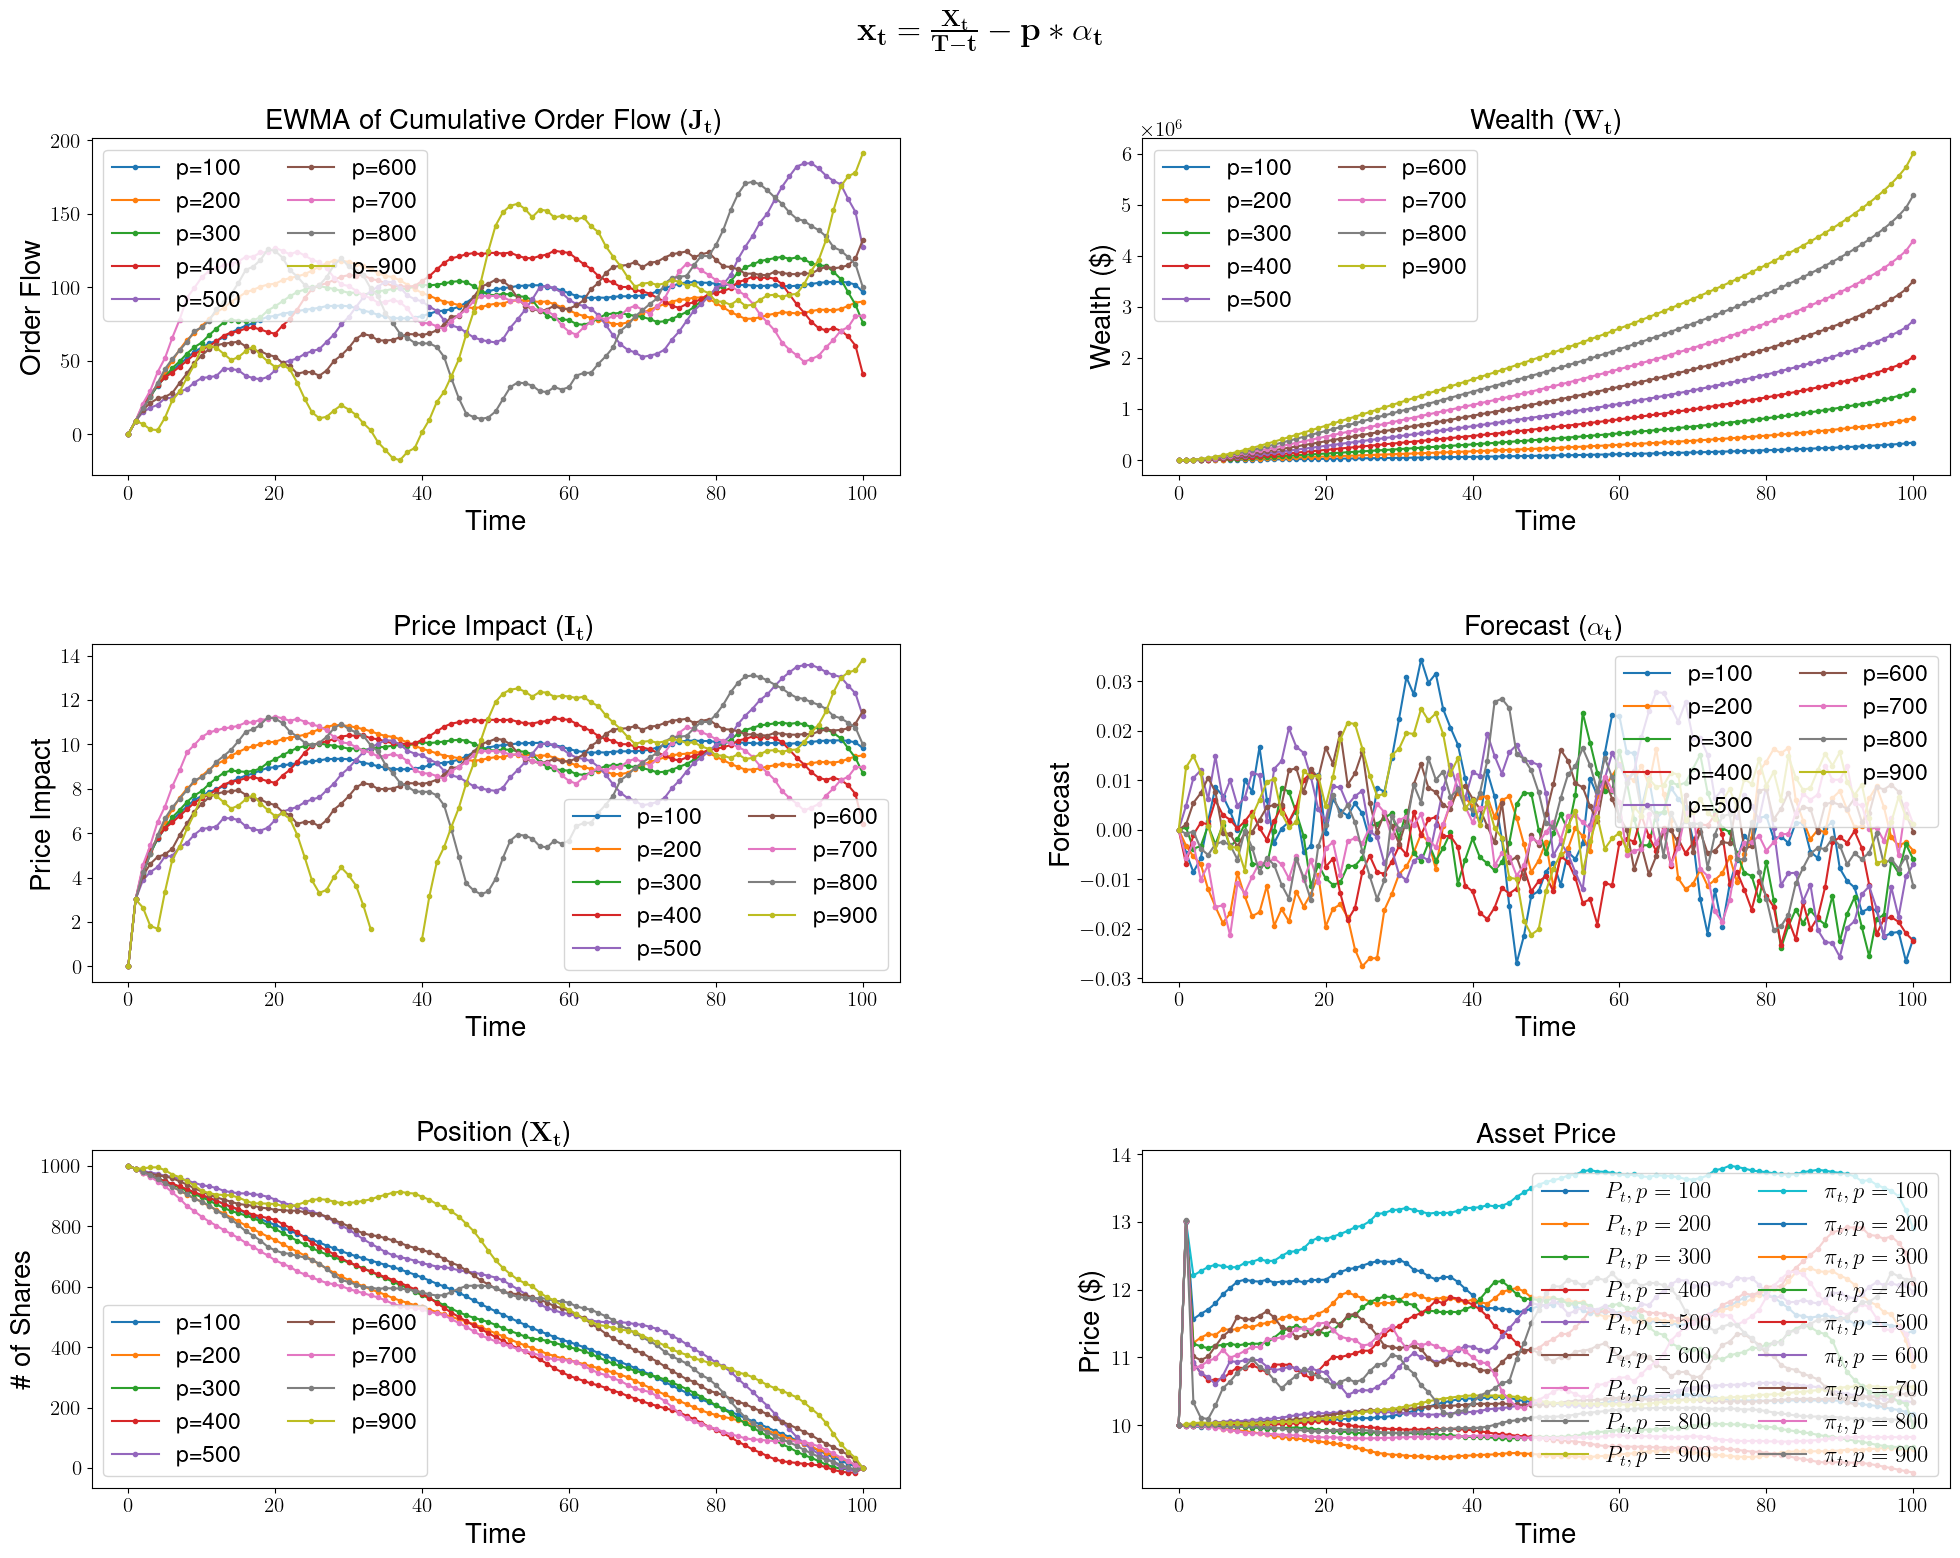

k: 900, final wealth: 6003199.164208625
k: 800, final wealth: 5181778.260493873
k: 700, final wealth: 4291344.841778718
k: 600, final wealth: 3502054.668969116
k: 500, final wealth: 2725250.8362126253
k: 400, final wealth: 2018272.5860787318
k: 300, final wealth: 1364131.263899135
k: 200, final wealth: 825485.0955531247
k: 100, final wealth: 344565.1189692804


In [60]:
def const_num_alpha(p, rem_t, rem_q, alpha, **kwargs):
    '''
    Calculates the number of shares to sell for constant fraction plus alpha
    '''
    # print(rem_q/rem_t - p * alpha)
    return rem_q/rem_t - p * alpha

const_num_alpha_df = pd.DataFrame()

d = {}

for i in range(1, 10):
    frac = 100 * i

    d[frac] = sim_MC(const_num_alpha, key_args = {'p': frac})

plt.show(plot_multi_results(r"$\mathbf{x_t=\frac{X_t}{T-t}-p*\alpha_t}$", d, logsc = False))

fin_w = {}
for k in d.keys():
    fin_w[k] = d[k]['W'].iloc[-1]

for k in sorted(fin_w, key=fin_w.get, reverse=True):
    print(f'k: {k}, final wealth: {fin_w[k]}')

In [54]:
# np.array(np.sqrt(d[10]['J']))==np.array(d[10]['I'])
print(np.sqrt(d[10]['J']))
print(d[10]['I'])

0      0.000000
1      3.015569
2      4.153318
3      4.956128
4      5.583118
         ...   
96     9.779426
97     9.783006
98     9.781539
99     9.784207
100    9.788979
Name: J, Length: 101, dtype: float64
0      0.000000
1      3.015569
2      4.113198
3      4.837201
4      5.355771
         ...   
96     8.396323
97     8.328390
98     8.238251
99     8.111295
100    7.841337
Name: I, Length: 101, dtype: float64


In [16]:
temp = {}
for k in d.keys():
    temp[k] = d[k]['W'].iloc[-1]
temp

{10: 23611.27646206167,
 20: 31906.519750980253,
 30: 42947.0661915474,
 40: 55071.61827185162,
 50: 69313.54003994224,
 60: 84519.88246662295,
 70: 99715.93493625557,
 80: 116090.92807105569,
 90: 132252.36544604605}